In [1]:
# Importing Libraries
import numpy as np  
from numpy import mean
from itertools import product
from itertools import permutations
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# there are lots of functions involved. A class is needed to hold them together.
class aggregation:
    def __init__(self, l, x, y): #initiation values. Every object should be initiated with these three values
        self.l= l #dimension of the input boxes. x and y should have the same dimension
        self.x=x
        self.y=y
    
    def get_boundary(self): #this is just the sum of x and y
        R=np.sum([self.x,self.y], axis=0) 
        return R
    
    def param_set(self):   #This method returns the parameter set which is the boundary of R
        R=self.get_boundary()
        lit=[]
        for i in range(self.l):
            lit.append(list(range(R[i]+1)))
        tot= list(product(*lit)) # all points in R including the interior
        param=[] #points on the boundary
        for item in tot:
            for i in range(self.l):
                if item[i]== 0 or item[i]==R[i]:
                    param.append(item)
        return list(set(param))
            
            
    def num_param(self): #this method returns the number of points in the parameter set; this comes from the theorem in the paper
        R= self.get_boundary()
        prod=1
        prud=1
        for i in range(self.l):
            prod= prod * (R[i]+1)
        for i in range(self.l):
            prud= prud * (R[i]-1)
        return prod-prud
            
    def aggregate(self,s): #for each s in the boundary of R, this returns the smallest box which contains x and y attached at the point s
        z=[]
        for i in range(self.l):
            z.append(max(self.x[i],self.y[i],self.x[i]+self.y[i]-s[i],s[i]))
        z.sort(reverse=True) #note that we have reversed z to make it a partition
        return z
    
    def aggregate_freq(self): #this method returns a dictionary, which contains the partitions and their frequency
        param= self.param_set()
        total_agg_set= []
        for s in param:
            total_agg_set.append(self.aggregate(s))
        counts = dict(Counter([tuple(sublist) for sublist in total_agg_set]).most_common())
        return counts
    
    def aggregate_num(self): #this returns the total number of aggregations with multiplicty
        dicti=self.aggregate_freq() #dictionary from above
        return sum(dicti.values())
         
    def dataframe(self): # this method creates a dataframe out of the aggregate_freq() output
        aggregate_freq= self.aggregate_freq()
        df_count = pd.DataFrame(aggregate_freq.items(), columns=['Dimensions', 'Count'])
        df_count['Percentage']= df_count['Count']*100/sum(df_count['Count'])
        df_count['Dimensions_arr']=df_count.apply(lambda row: np.array(row['Dimensions']), axis=1)
        return df_count
    
    def plot_freq(self): #this method returns a plot of the partions vs frequency
        df=self.dataframe()
        plt.figure(figsize=(12,7))
        sns.barplot(data=df, x="Dimensions", y="Count")
        plt.xticks(rotation=90,fontsize=10)
        plt.show()
        
    def plot_probab(self): #this method returns a plot of the percentage vs frequency (same as plot_freq())
        df= self.dataframe() 
        plt.figure(figsize=(12,7))
        sns.barplot(data=df, x="Dimensions", y="Percentage")
        plt.xticks(rotation=90)
        plt.show()
     
    def plot_probab_bydimen(self): #this method returns a plot as before, but the partitions are arranged in increasing order
        df= self.dataframe()
        df.sort_values(by='Dimensions', inplace=True) #this is differnt from above
        plt.figure(figsize=(12,7))
        sns.barplot(data=df, x="Dimensions", y="Percentage")
        plt.xticks(rotation=90)
        plt.show()
    
    def stat(self): #this method returns the mean value of the dimension
        df= self.dataframe()
        mean=sum(df['Count']*df['Dimensions_arr'])/sum(df['Count'])
        print("Mean is ",mean )
        
        
    #tool 2 functions
    def permute(self):
        sigma= [np.array(item) for item in list(permutations(self.y))]
        return sigma
    
    def rotate_freq(self): #this is aggregation frequncy but now with rotations included. 
        classes=[]
        for item in self.permute():
            classes.append(aggregation(self.l,self.x, item))
        dictionaries=Counter({}) #empty dicitonary
        for item in classes:
            dictionaries+=Counter(item.aggregate_freq()) 
        df_counter = pd.DataFrame(dict(dictionaries).items(), columns=['Dimensions', 'Count'])
        df_counter['Percentage']= df_counter['Count']*100/sum(df_counter['Count'])
        df_counter['Dimensions_arr']=df_counter.apply(lambda row: np.array(row['Dimensions']), axis=1) #we need the array values instead of tuple values for the partitions so one extra column
        df_counter.sort_values(by='Count', inplace=True, ascending=False)
        df_counter = df_counter.reset_index(drop=True)
        return df_counter
    
    def plot_rotate_freq(self):
        df= self.rotate_freq()
        plt.figure(figsize=(12,10))
        sns.barplot(data=df, x="Dimensions", y="Count")
        plt.xticks(rotation=90)
        plt.show()
        
    def plot_prob_rotate_freq(self):
        df= self.rotate_freq()
        plt.figure(figsize=(12,10))
        sns.barplot(data=df, x="Dimensions", y="Percentage")
        plt.xticks(rotation=90)
        plt.show()
        
    def plot_rotate_freqbydim(self):
        df= self.rotate_freq()
        df.sort_values(by='Dimensions', inplace=True)
        plt.figure(figsize=(12,10))
        sns.barplot(data=df, x="Dimensions", y="Percentage")
        plt.xticks(rotation=90)
        plt.show()
        
    def ratios(self): #with rotations only
        df_counter= self.rotate_freq()
        for i in range(self.l-1):
            df_counter['L'+str(i+1)]= df_counter.apply(lambda row: row['Dimensions_arr'][i]/row['Dimensions_arr'][i+1], axis=1)
        return df_counter
    
    def plot_ratios(self): #with rotations only
        df_counter= self.ratios()
        for i in range(l-1):
            df_new=df_counter.groupby(['L'+str(i+1)])['Count'].sum().sort_values(ascending=False).reset_index()
            plt.figure(figsize=(12,10))
            sns.barplot(data=df_new, x="L"+str(i+1), y="Count")
            plt.xticks(rotation=90)
            plt.show()
            
    def get_ratio_nd(self,s):
        z= self.aggregate(s)
        L=[]
        for i in range(len(z)-1):
            L.append(z[i]/z[i+1])
        return L           
#         if z[0]>z[1] or z[0]==z[1]:
#             return z[0]/z[1]
#         else:
#             return z[1]/z[0]
    
    def get_ratios_woutrot_2dfreq(self): #ratios for without rotation only for 2d
        param= self.param_set()
        total_agg_set= []
        for s in param:
            ratios= self.get_ratio_nd(s)
            total_agg_set.append(ratios[0])
        counts = dict(Counter(total_agg_set).most_common())
        return counts
    
    def get_ratios_withrot_2dfreq(self):
        classes=[]
        for item in self.permute():
            classes.append(aggregation(self.l,self.x, item))
        dictionaries=Counter({}) #empty dicitonary
        for item in classes:
            dictionaries+=Counter(item.get_ratios_woutrot_2dfreq()) 
        return dict(dictionaries)
    
    def get_ratios_woutrot_ndfreq(self): #ratios for without rotation for any dimensions
        param= self.param_set()
        total_agg_set= []
        for s in param:
            total_agg_set.append(self.get_ratio_nd(s))
        counts = dict(Counter(total_agg_set).most_common())
        return counts
        

# Example with boxes of dimension 1 x 1 and 1 x 1

In [3]:
x1=np.array([1,1])
y1=np.array([1,1])
l1=len(x1) #can do this manually

In [4]:
aggie1= aggregation(l1, x1, y1) #aggie is an object of type aggregation 

In [5]:
aggie1.param_set()

[(0, 1), (1, 2), (2, 1), (0, 0), (2, 0), (0, 2), (2, 2), (1, 0)]

In [6]:
aggie1.num_param()

8

In [7]:
aggie1.aggregate_freq()

{(2, 1): 4, (2, 2): 4}

In [8]:
aggie1.aggregate_num()

8

In [9]:
aggie1.dataframe()

,Dimensions,Count,Percentage,Dimensions_arr
0,"(2, 1)",4,50.0,"[2, 1]"
1,"(2, 2)",4,50.0,"[2, 2]"


In [10]:
aggie1.rotate_freq()

,Dimensions,Count,Percentage,Dimensions_arr
0,"(2, 1)",8,50.0,"[2, 1]"
1,"(2, 2)",8,50.0,"[2, 2]"


# Example with boxes of dimension 1x1x1 and 1x1x1

In [11]:
x2=np.array([1,1,1])
y2=np.array([1,1,1])
l2=len(x2) #can do this manually

In [12]:
aggie2= aggregation(l2,x2, y2) #aggie is an object of type aggregation 

In [13]:
aggie2.param_set()

[(2, 0, 2),
 (0, 1, 0),
 (2, 2, 2),
 (2, 1, 0),
 (1, 2, 2),
 (0, 0, 1),
 (0, 2, 1),
 (1, 0, 1),
 (1, 1, 0),
 (2, 0, 1),
 (2, 1, 2),
 (2, 2, 1),
 (0, 1, 2),
 (1, 2, 1),
 (0, 2, 0),
 (0, 0, 0),
 (1, 1, 2),
 (1, 0, 0),
 (2, 0, 0),
 (2, 2, 0),
 (0, 1, 1),
 (2, 1, 1),
 (1, 2, 0),
 (0, 0, 2),
 (0, 2, 2),
 (1, 0, 2)]

In [14]:
aggie2.num_param()

26

In [15]:
aggie2.aggregate_freq()

{(2, 2, 1): 12, (2, 2, 2): 8, (2, 1, 1): 6}

In [16]:
aggie2.aggregate_num()

26

In [17]:
aggie2.dataframe()

,Dimensions,Count,Percentage,Dimensions_arr
0,"(2, 2, 1)",12,46.153846,"[2, 2, 1]"
1,"(2, 2, 2)",8,30.769231,"[2, 2, 2]"
2,"(2, 1, 1)",6,23.076923,"[2, 1, 1]"


In [18]:
aggie2.rotate_freq()

,Dimensions,Count,Percentage,Dimensions_arr
0,"(2, 2, 1)",72,46.153846,"[2, 2, 1]"
1,"(2, 2, 2)",48,30.769231,"[2, 2, 2]"
2,"(2, 1, 1)",36,23.076923,"[2, 1, 1]"


# Examples from previous notebooks

In [19]:
x=np.array([1,2,3])
y=np.array([7,10,13])
l=len(x) #can do this manually

In [20]:
aggie= aggregation(l,x, y) #aggie is an object of type aggregation 

In [21]:
aggie.aggregate_freq()

{(13, 10, 8): 198,
 (13, 12, 7): 154,
 (16, 10, 7): 126,
 (13, 11, 8): 44,
 (13, 12, 8): 44,
 (15, 10, 8): 36,
 (16, 10, 8): 36,
 (14, 10, 8): 36,
 (15, 12, 7): 28,
 (16, 12, 7): 28,
 (14, 12, 7): 28,
 (16, 11, 7): 28,
 (14, 12, 8): 8,
 (16, 11, 8): 8,
 (14, 11, 8): 8,
 (15, 12, 8): 8,
 (15, 11, 8): 8,
 (16, 12, 8): 8}

In [22]:
x=np.array([3,4])
y=np.array([4,4])
agg= aggregation(2,x,y)

In [23]:
agg.get_ratios_woutrot_2dfreq()

{2.0: 4,
 1.1666666666666667: 4,
 1.4: 4,
 1.3333333333333333: 4,
 1.1428571428571428: 4,
 1.6: 4,
 1.0: 4,
 1.75: 2}

In [24]:
Counter(agg.get_ratios_woutrot_2dfreq())+Counter({1.0:1})

Counter({1.0: 5,
         2.0: 4,
         1.1666666666666667: 4,
         1.4: 4,
         1.3333333333333333: 4,
         1.1428571428571428: 4,
         1.6: 4,
         1.75: 2})

In [25]:
aggie.num_param() #this is giving the points in $T=\boundary R$ but unordered (not partion). This comes from the theorem in the paper

834

In [26]:
aggie.aggregate_num()

834

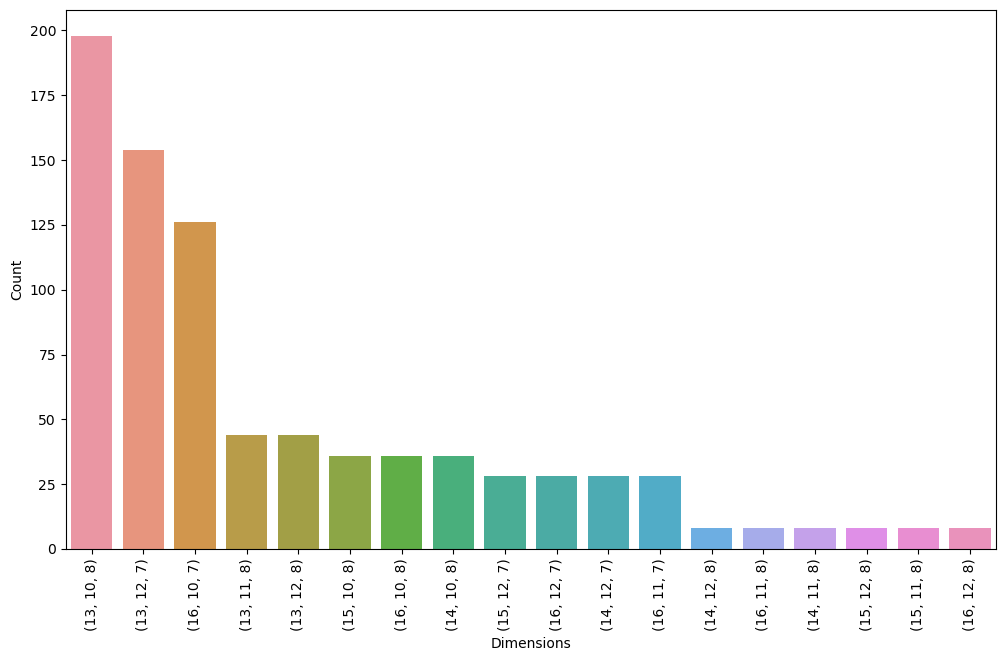

In [27]:
aggie.plot_freq()

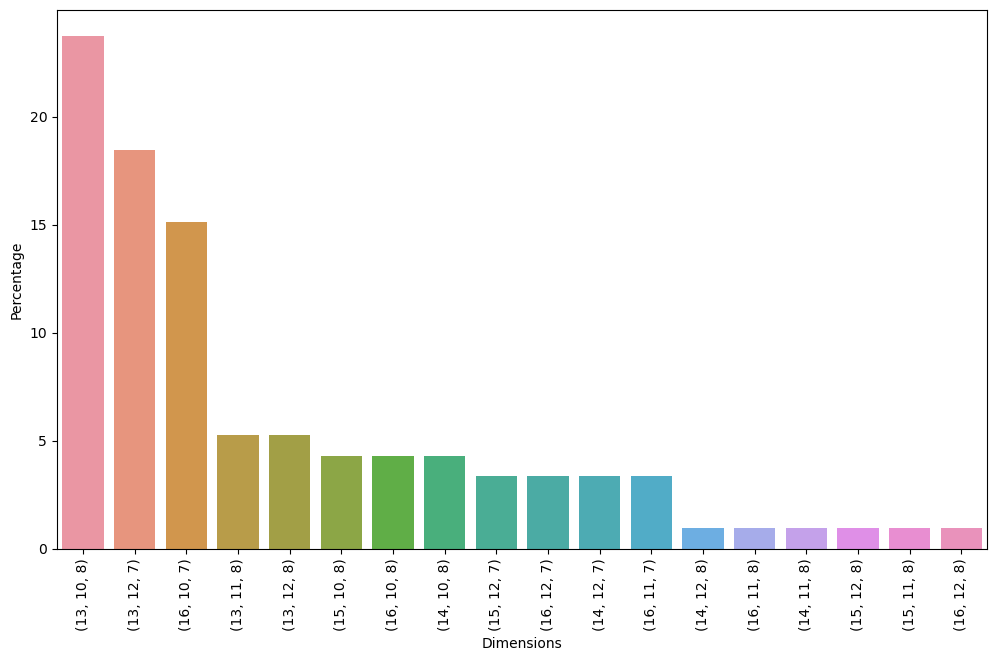

In [28]:
aggie.plot_probab()

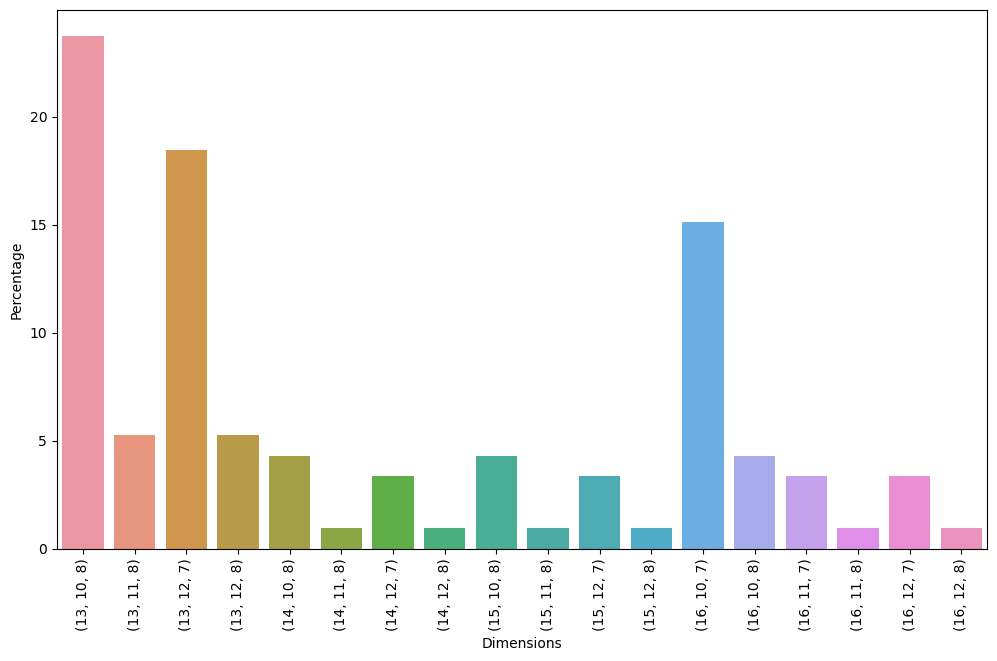

In [29]:
aggie.plot_probab_bydimen()

In [30]:
aggie.stat()

Mean is  [14.1294964  10.84892086  7.52997602]


# Tool 2

In [31]:
# lets take different x and y
x1=np.array([3,2,1]) # lets assume nonincreasing order for now
y1=np.array([13,10,4]) # lets assume nonincreasing order for now
l1=3

In [32]:
aggieville= aggregation(l1,x1, y1)

In [33]:
aggieville.permute()

[array([13, 10,  4]),
 array([13,  4, 10]),
 array([10, 13,  4]),
 array([10,  4, 13]),
 array([ 4, 13, 10]),
 array([ 4, 10, 13])]

In [34]:
aggieville.rotate_freq()

,Dimensions,Count,Percentage,Dimensions_arr
0,"(13, 10, 7)",474,11.549708,"[13, 10, 7]"
1,"(13, 10, 6)",428,10.428850,"[13, 10, 6]"
2,"(13, 10, 5)",390,9.502924,"[13, 10, 5]"
3,"(13, 11, 5)",184,4.483431,"[13, 11, 5]"
4,"(13, 13, 4)",174,4.239766,"[13, 13, 4]"
5,"(13, 12, 5)",144,3.508772,"[13, 12, 5]"
6,"(13, 11, 6)",144,3.508772,"[13, 11, 6]"
7,"(13, 12, 4)",140,3.411306,"[13, 12, 4]"
8,"(14, 10, 5)",136,3.313840,"[14, 10, 5]"
9,"(16, 10, 4)",132,3.216374,"[16, 10, 4]"


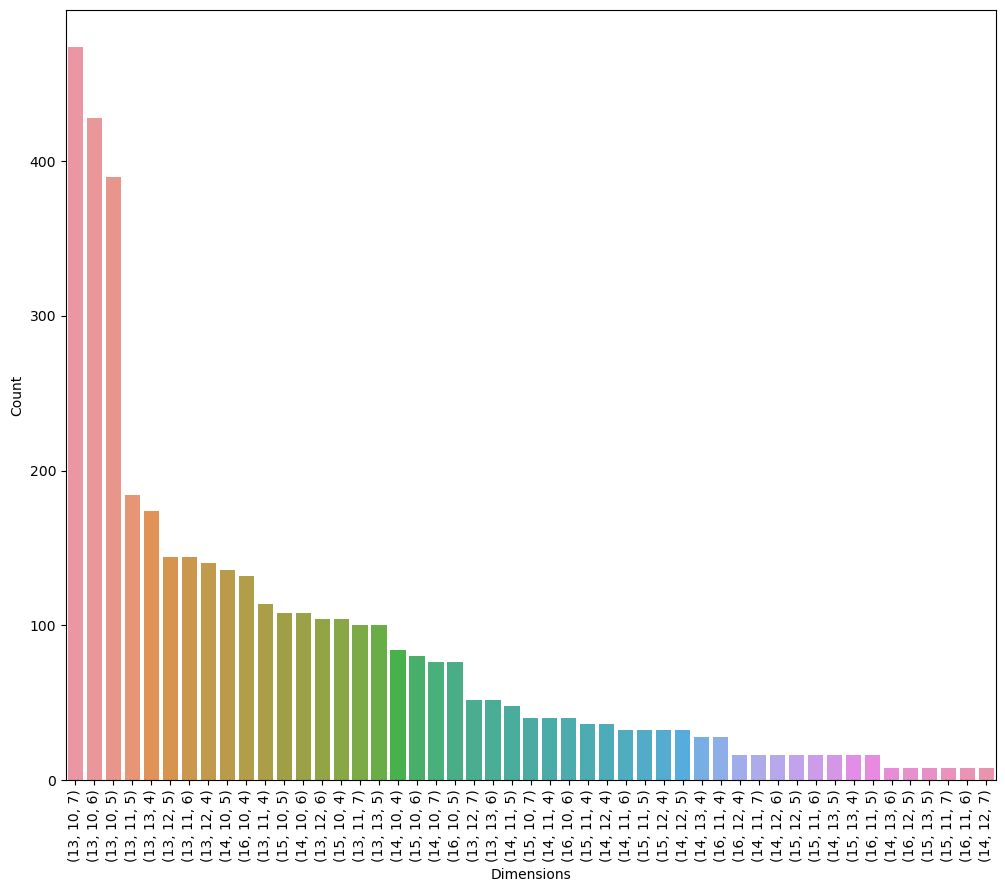

In [35]:
aggieville.plot_rotate_freq()

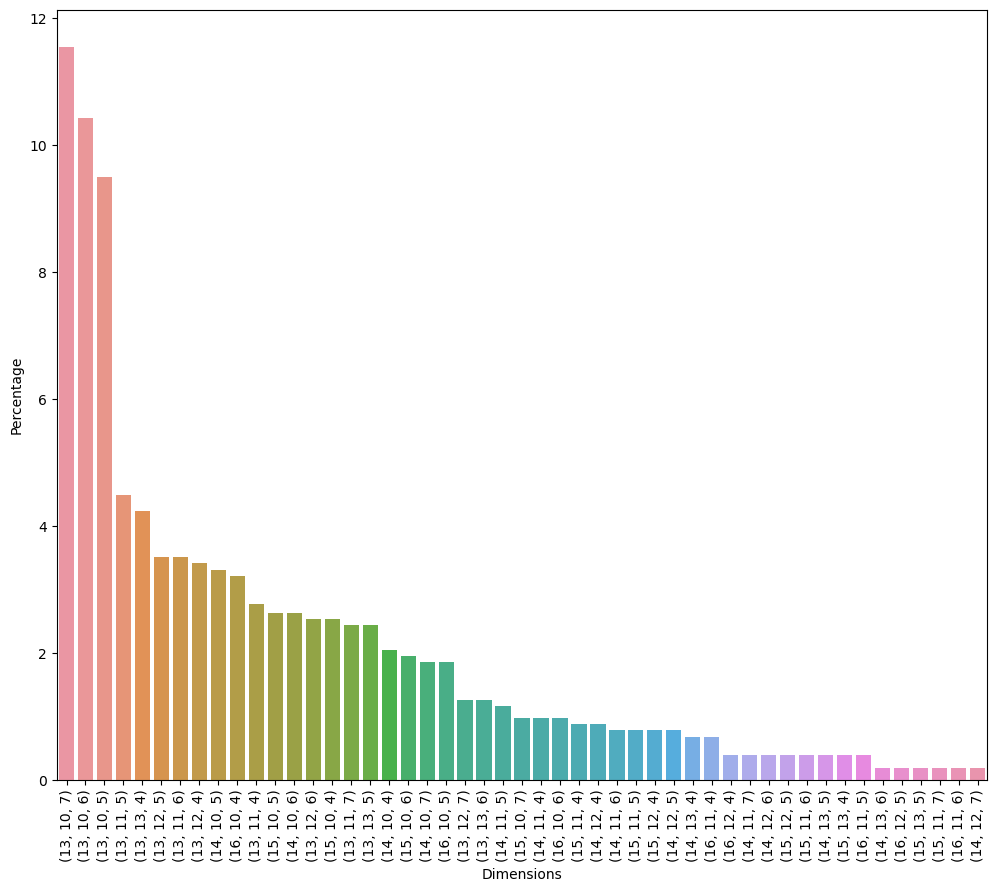

In [36]:
aggieville.plot_prob_rotate_freq()

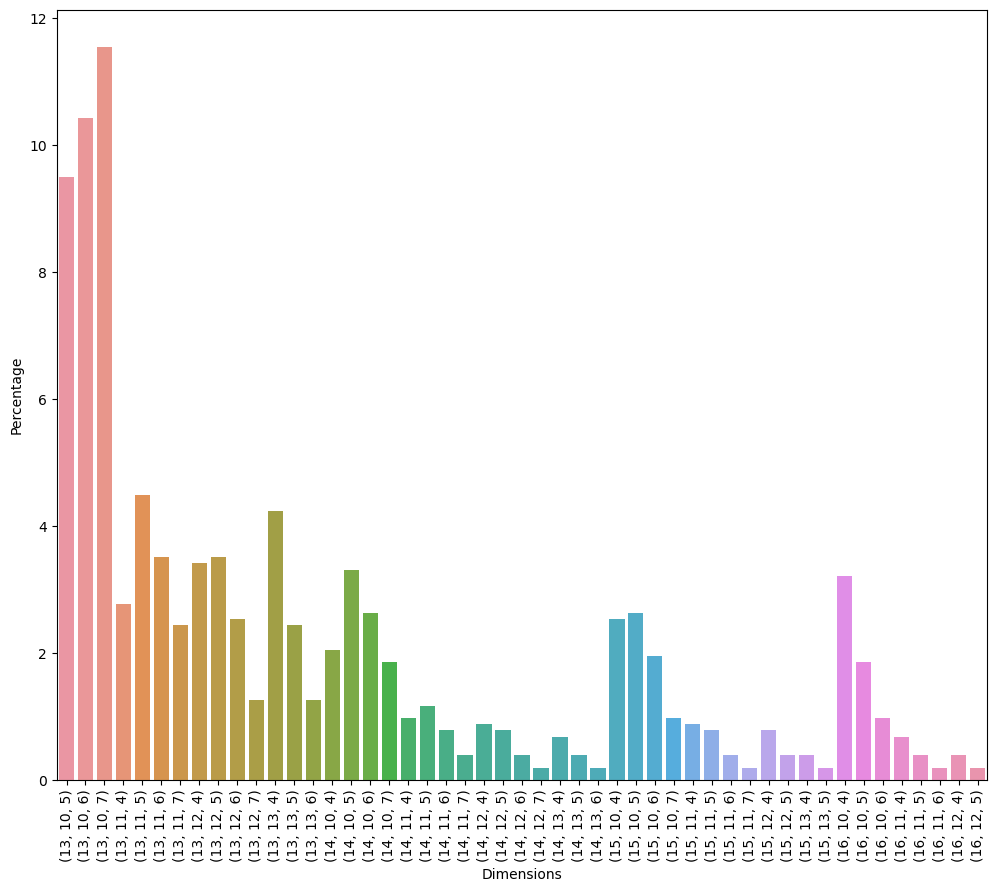

In [37]:
aggieville.plot_rotate_freqbydim()

In [38]:
aggieville.ratios()

,Dimensions,Count,Percentage,Dimensions_arr,L1,L2
0,"(13, 10, 7)",474,11.549708,"[13, 10, 7]",1.300000,1.428571
1,"(13, 10, 6)",428,10.428850,"[13, 10, 6]",1.300000,1.666667
2,"(13, 10, 5)",390,9.502924,"[13, 10, 5]",1.300000,2.000000
3,"(13, 11, 5)",184,4.483431,"[13, 11, 5]",1.181818,2.200000
4,"(13, 13, 4)",174,4.239766,"[13, 13, 4]",1.000000,3.250000
5,"(13, 12, 5)",144,3.508772,"[13, 12, 5]",1.083333,2.400000
6,"(13, 11, 6)",144,3.508772,"[13, 11, 6]",1.181818,1.833333
7,"(13, 12, 4)",140,3.411306,"[13, 12, 4]",1.083333,3.000000
8,"(14, 10, 5)",136,3.313840,"[14, 10, 5]",1.400000,2.000000
9,"(16, 10, 4)",132,3.216374,"[16, 10, 4]",1.600000,2.500000


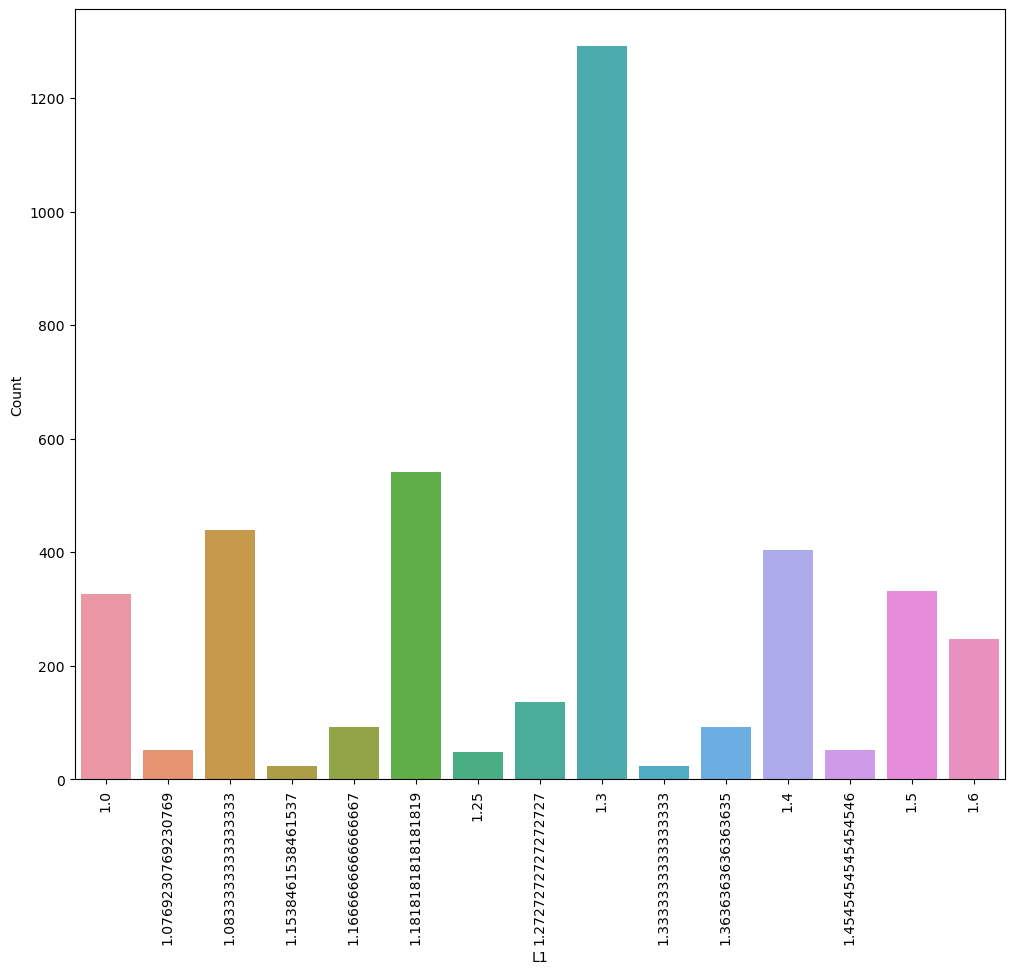

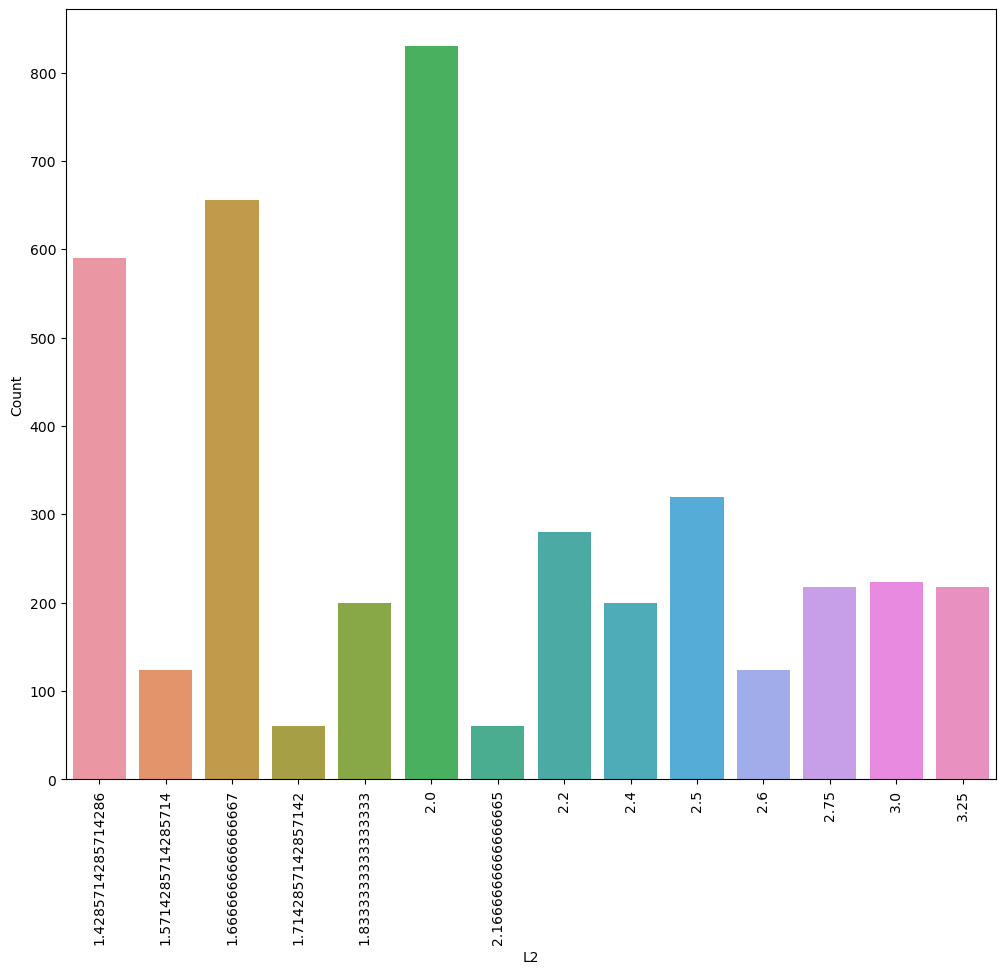

In [39]:
aggieville.plot_ratios()

# Simulation 2d
# Without rotation first

In [40]:
# highest_val is the highest value for the random integer generation of the entries of x and y
def simulation_2d(num_times, highest_val): #num_times is the number of times you want the simulation to run
    dicti=Counter({})
    for i in range(num_times):
        x=np.random.randint(1,highest_val,size=2) #20 is max size #1 is min
        y=np.random.randint(1,highest_val,size=2) #2o is max 1 is min
        agg_obj= aggregation(2,x,y)
        dicti+=Counter(agg_obj.get_ratios_woutrot_2dfreq())  #
    df_count = pd.DataFrame(dict(dicti).items(), columns=['ratio', 'Count'])
    df_count.sort_values(by='Count', inplace=True, ascending=False)
    df_count = df_count.reset_index(drop=True)
    plt.figure(figsize=(30,20))
    sns.barplot(data=df_count , x="ratio", y="Count")
    plt.xticks(rotation=90,fontsize=4)
    plt.show()
    return df_count

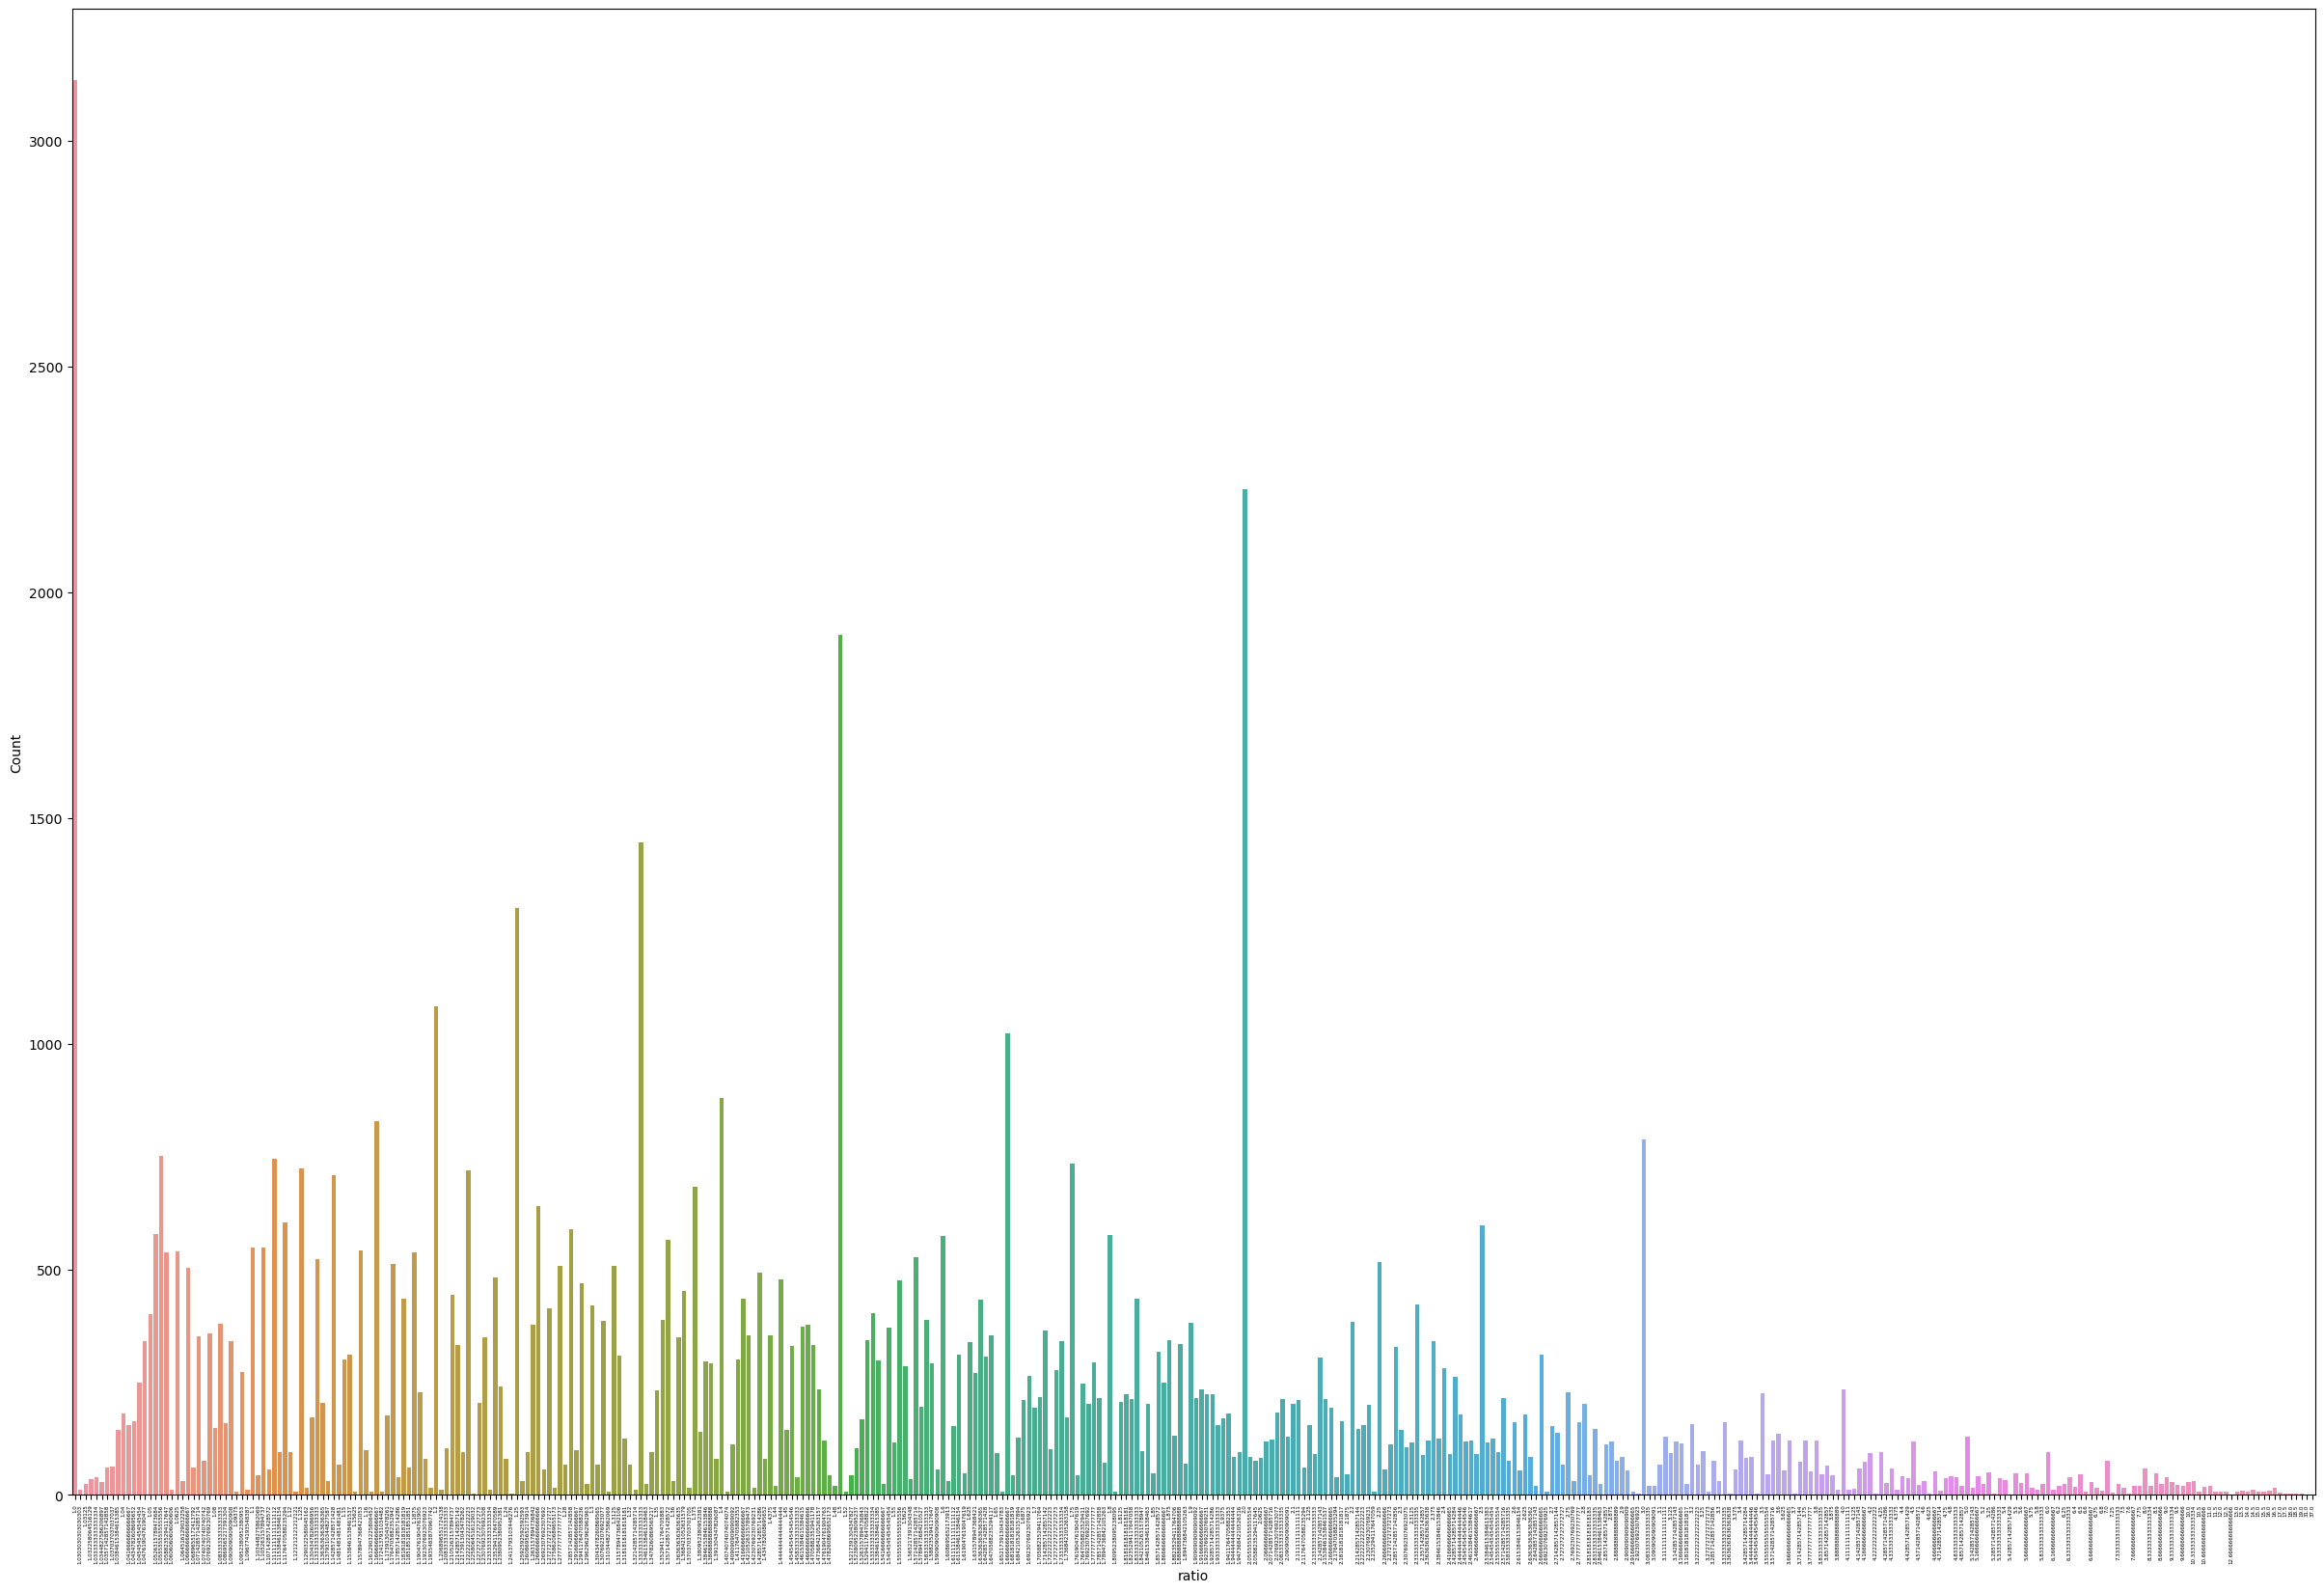

,ratio,Count
0,1.000000,3136
1,2.000000,2228
2,1.500000,1906
3,1.333333,1446
4,1.250000,1300
...,...,...
411,18.500000,4
412,5.428571,2
413,31.000000,2
414,12.666667,2


In [41]:
simulation_2d(1000, 20) #1000 times, max value for the entries of x and y is 20

# Allowing rotation

In [42]:
# highest_val is the highest value for the random integer generation of the entries of x and y
def simulation_2d_rot(num_times, highest_val): #num_times is the number of times you want the simulation to run
    dicti=Counter({})
    for i in range(num_times):
        x=np.random.randint(1,highest_val,size=2) #20 is max size #1 is min
        y=np.random.randint(1,highest_val,size=2) #2o is max 1 is min
        agg_obj= aggregation(2,x,y)
        dicti+=Counter(agg_obj.get_ratios_withrot_2dfreq())  # this line is different from above
    df_count = pd.DataFrame(dict(dicti).items(), columns=['ratio', 'Count'])
    df_count.sort_values(by='Count', inplace=True, ascending=False)
    df_count = df_count.reset_index(drop=True)
    plt.figure(figsize=(30,20))
    sns.barplot(data=df_count , x="ratio", y="Count")
    plt.xticks(rotation=90,fontsize=4)
    plt.show()
    return df_count

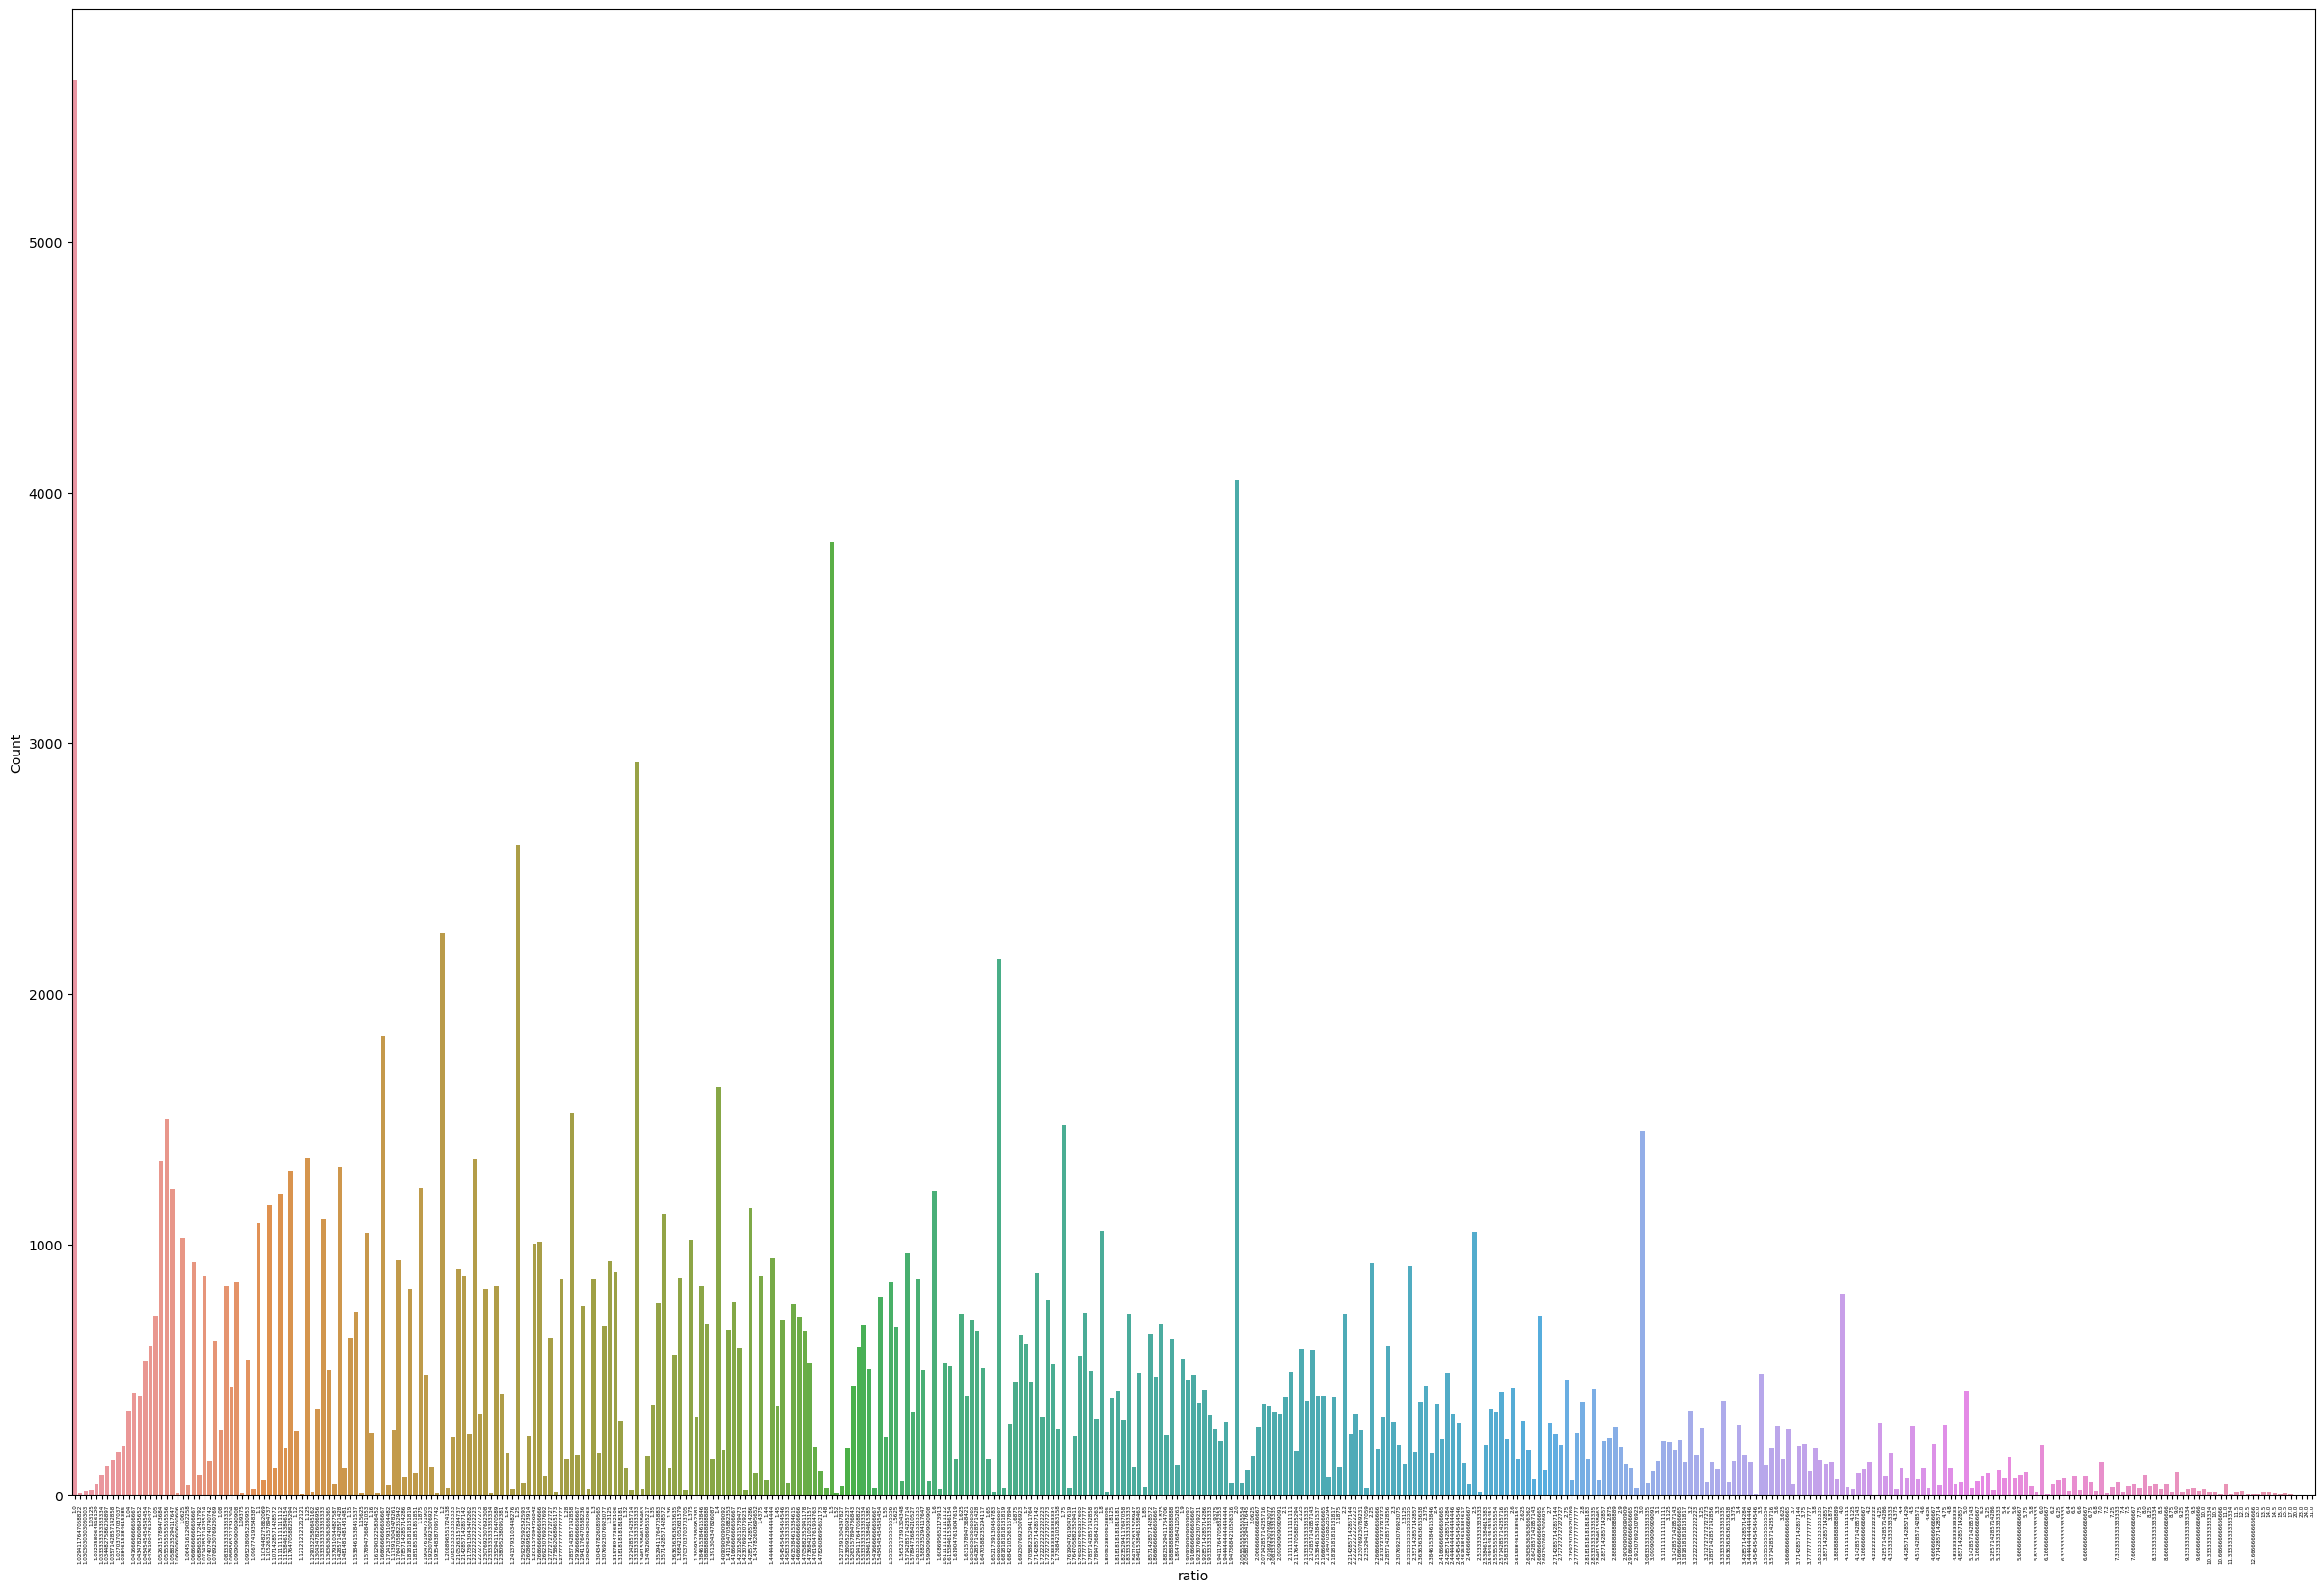

,ratio,Count
0,1.000000,5648
1,2.000000,4048
2,1.500000,3804
3,1.333333,2924
4,1.250000,2592
...,...,...
410,4.222222,2
411,31.000000,2
412,24.000000,2
413,23.000000,2


In [43]:
simulation_2d_rot(1000, 20) #1000 times, max value for the entries of x and y is 20

# Realized that in the previous simulation the s from the parameter set was not chosen randomly. Aggregations for all the s were counted. In the following simulations, s is chosen randomly.

In [44]:
# highest_val is the highest value for the random integer generation of the entries of x and y
# it only counts the first ratio
# it can be modified to plot other ratios as well
def simulation_nd(dim, num_times, highest_val): #num_times is the number of times you want the simulation to run
    dicti=Counter({})
    L_ratios=[]
    for i in range(num_times):
        x=np.random.randint(1,highest_val,size=dim) #20 is max size #1 is min
        y=np.random.randint(1,highest_val,size=dim) #2o is max 1 is min
        agg_obj= aggregation(dim,x,y)
        param_set= agg_obj.param_set()
        s= param_set[np.random.randint(1,len(param_set))]
        #s= np.random.choice(agg_obj.param_set())
        L_ratios.append(agg_obj.get_ratio_nd(s))
    L_zero= [item[0] for item in L_ratios]  #only first ratio l_1= z_1/z_2 for all iterations of simulation
    L_count= dict(Counter(L_zero))
    df_count = pd.DataFrame(dict(L_count).items(), columns=['first ratio', 'Count'])
    df_count.sort_values(by='Count', inplace=True, ascending=False)
    df_count = df_count.reset_index(drop=True)
    plt.figure(figsize=(30,20))
    sns.barplot(data=df_count , x="first ratio", y="Count")
    plt.xticks(rotation=90,fontsize=4)
    plt.show()
    return df_count

# Simulation 2d
Note again: this is where s is chosen randomly

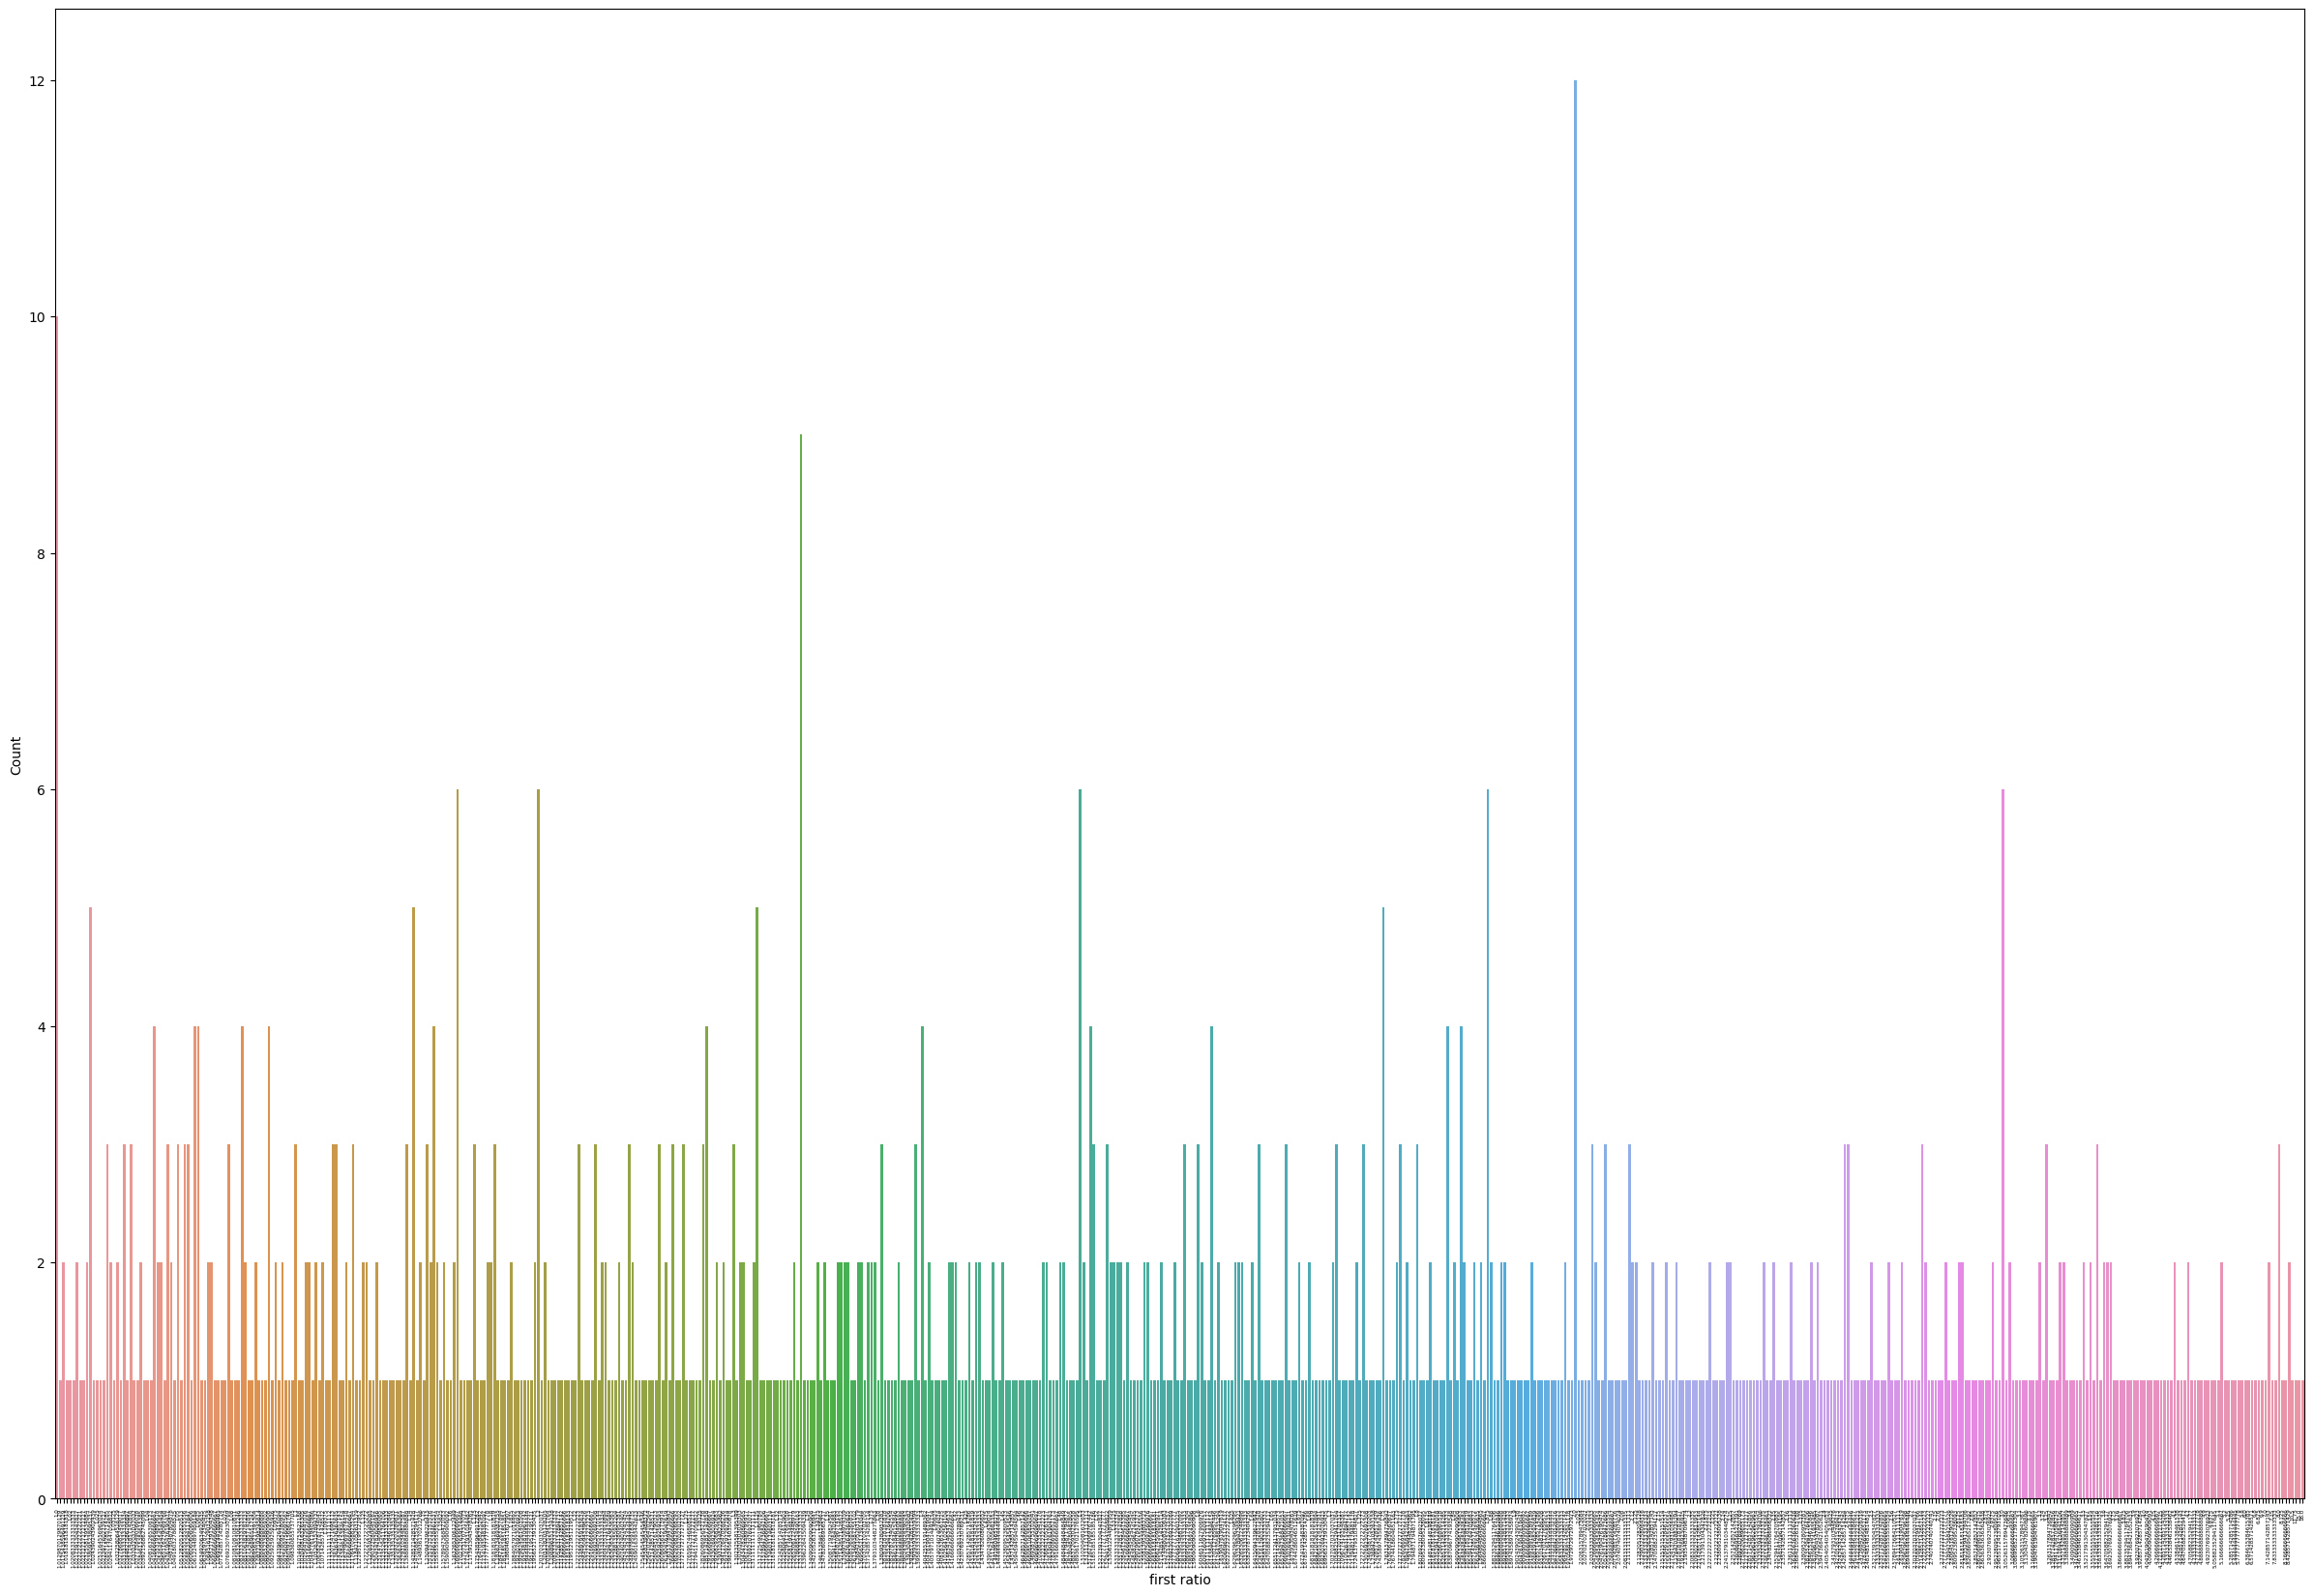

,first ratio,Count
0,2.000000,12
1,1.000000,10
2,1.333333,9
3,1.875000,6
4,3.000000,6
...,...,...
663,1.298246,1
664,8.166667,1
665,2.629630,1
666,1.089552,1


In [45]:
simulation_nd(2, 1000, 50)

# Simulation 3d

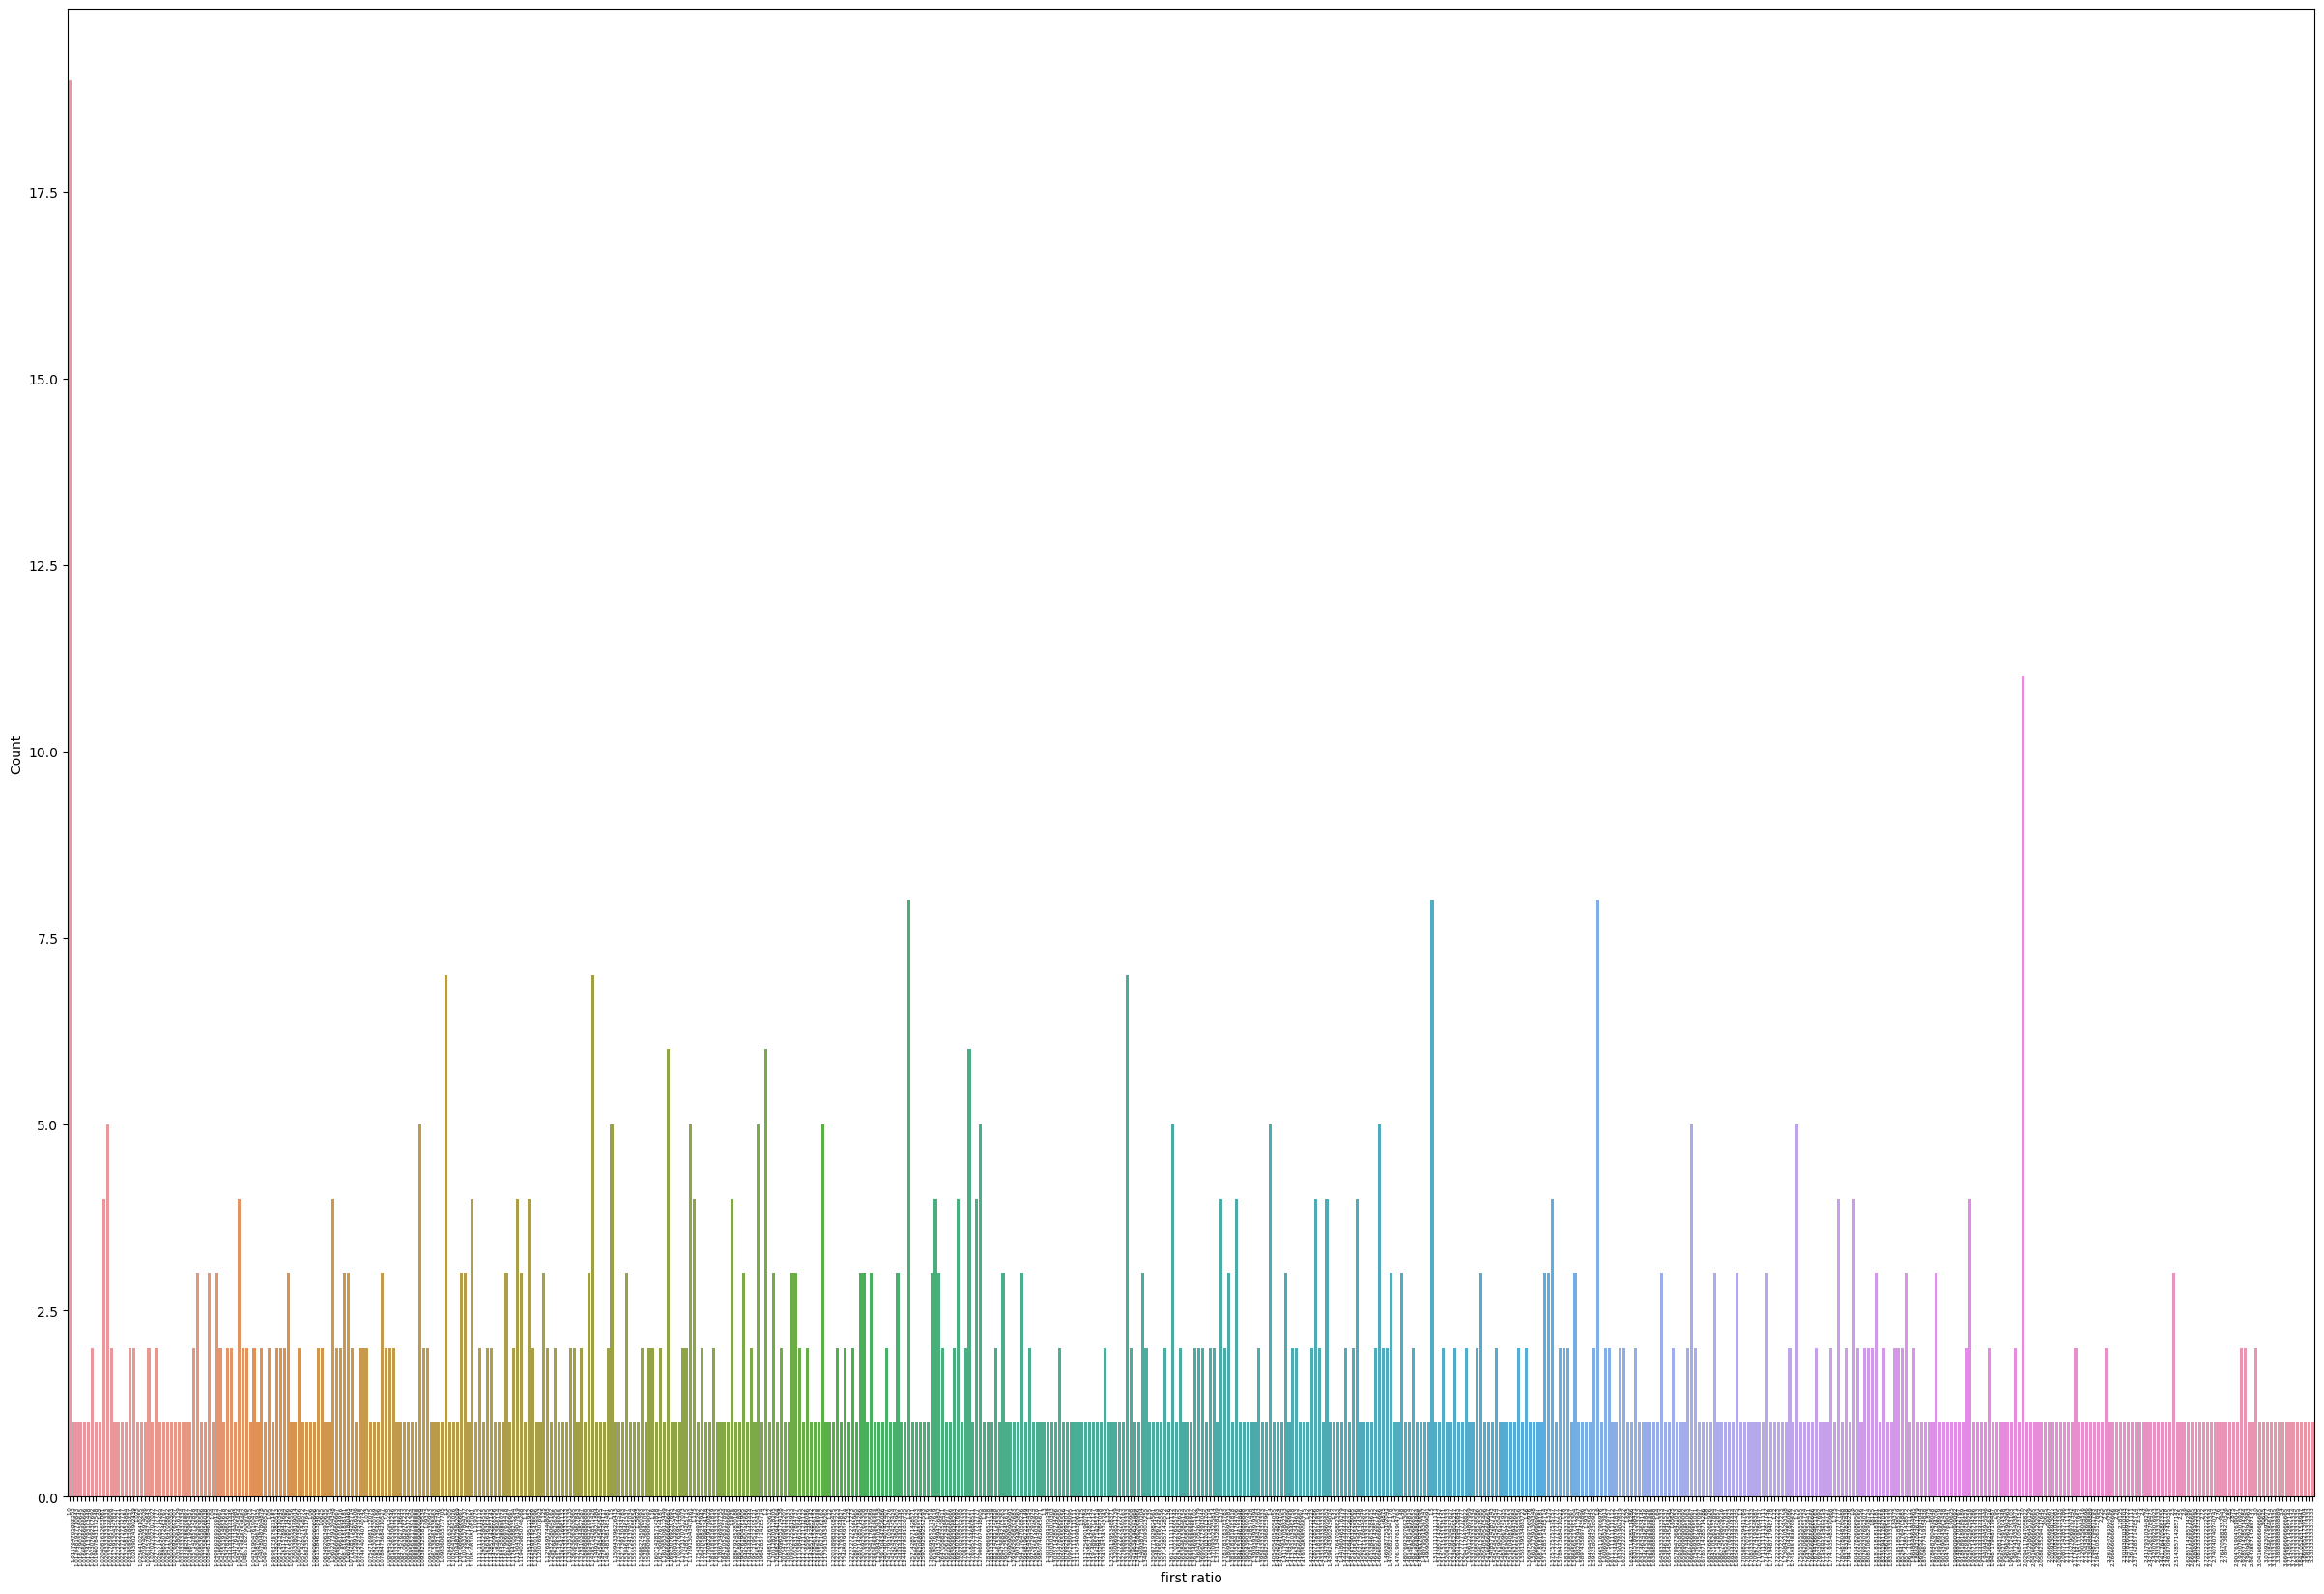

,first ratio,Count
0,1.000000,19
1,2.000000,11
2,1.600000,8
3,1.500000,8
4,1.250000,8
...,...,...
592,1.565217,1
593,1.456522,1
594,1.244444,1
595,2.689655,1


In [46]:
simulation_nd(3,1000, 50)